In [ ]:
import io, os, sys, setuptools, tokenize

In [ ]:
!pip install prophet
import prophet

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/cleaned.csv")

df.columns = ['unamed','lat', 'lon', 'price_1_day', 'kitchen', 'free_parking',
              'security_camera', 'elevator', 'guests', 'beds',
              'bedrooms', 'bathrooms', 'host experience', 'TV_features', 'laundry',
              'air_conditioning', 'dryer', 'swimming_pool', 'year', 'month']
df['timestamp'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Drop unnecessary columns
df = df[['lat', 'lon', 'price_1_day', 'timestamp']]

# Group by timestamp, lat, lon and calculate mean price
df_mean_price = df.groupby(['timestamp', 'lat', 'lon'])['price_1_day'].mean().reset_index()

# Create a new DataFrame with duplicate instances having the mean price
df_new = df.merge(df_mean_price, on=['timestamp', 'lat', 'lon'], suffixes=('_original', '_mean'))

# Drop the original price column and rename the mean price column
df_new = df_new.drop('price_1_day_original', axis=1)
df_new = df_new.rename(columns={'price_1_day_mean': 'price_1_day'})

# Create 'hotel_id' column
df_new['hotel_id'] = df_new['lat'].astype(str) + ',' + df_new['lon'].astype(str)

print(df_new)


           lat        lon  timestamp  price_1_day            hotel_id
0     21.03382  105.82192 2025-01-01     256000.0  21.03382,105.82192
1     21.06280  105.82350 2025-01-01     439457.5    21.0628,105.8235
2     21.06120  105.82640 2025-01-01     370362.0    21.0612,105.8264
3     21.03133  105.82217 2025-01-01     255000.0  21.03133,105.82217
4     21.02670  105.84210 2025-01-01     473901.0    21.0267,105.8421
...        ...        ...        ...          ...                 ...
4940  21.02548  105.82108 2026-12-01    1108333.0  21.02548,105.82108
4941  21.21680  105.78120 2026-12-01     348333.0    21.2168,105.7812
4942  21.07339  105.82542 2026-12-01     536359.0  21.07339,105.82542
4943  21.20283  105.83210 2026-12-01     495000.0   21.20283,105.8321
4944  21.02060  105.77910 2026-12-01     725000.0    21.0206,105.7791

[4945 rows x 5 columns]


In [ ]:
# Create a DataFrame with all possible timestamps for each hotel
min_timestamp = df_new['timestamp'].min()
max_timestamp = df_new['timestamp'].max()
all_timestamps = pd.date_range(min_timestamp, max_timestamp, freq='MS')

# Create a new DataFrame with all possible timestamps for each hotel
df_all_timestamps = pd.DataFrame(index=all_timestamps)
df_all_timestamps['timestamp'] = df_all_timestamps.index

# Create a new DataFrame with all possible timestamps for each hotel
df_filled = pd.merge(df_all_timestamps.assign(key=1), df_new[['hotel_id']].drop_duplicates().assign(key=1), on='key').drop('key', axis=1)
df_filled = df_filled.merge(df_new, on=['timestamp', 'hotel_id'], how='left')

# Fill in null values with the average price over all timestamps for each hotel
null_percent = df_filled.groupby('hotel_id')['price_1_day'].apply(lambda x: x.isnull().mean() * 100)
drop_hotels = null_percent[null_percent >= 50].index

# Drop hotel rooms with null percent >= 50% over a period
df_filled = df_filled[~df_filled['hotel_id'].isin(drop_hotels)]

# Fill in null values with the average price over all timestamps for each hotel
df_filled['price_1_day'] = df_filled.groupby('hotel_id')['price_1_day'].transform(lambda x: x.fillna(x.mean()))

# Fill in null values with the average price over all timestamps for each hotel
df_filled['price_1_day'] = df_filled.groupby('hotel_id')['price_1_day'].transform(lambda x: x.fillna(x.mean()))

# Drop the rows where hotel_id is null (these are the rows where the hotel_id did not exist in the original DataFrame)
df_filled = df_filled.dropna(subset=['hotel_id'])

print(df_filled)

       timestamp            hotel_id       lat        lon  price_1_day
12    2025-01-01    21.0267,105.8421  21.02670  105.84210     473901.0
13    2025-01-01    21.0267,105.8421  21.02670  105.84210     473901.0
14    2025-01-01    21.0267,105.8421  21.02670  105.84210     473901.0
15    2025-01-01    21.0212,105.8474  21.02120  105.84740     549813.0
16    2025-01-01    21.0212,105.8474  21.02120  105.84740     549813.0
...          ...                 ...       ...        ...          ...
18685 2026-12-01  21.03303,105.81528       NaN        NaN    1260000.0
18687 2026-12-01  21.08152,105.81541  21.08152  105.81541    1678333.0
18688 2026-12-01  21.08152,105.81541  21.08152  105.81541    1678333.0
18696 2026-12-01  21.05279,105.83459  21.05279  105.83459     497979.0
18697 2026-12-01  21.05279,105.83459  21.05279  105.83459     497979.0

[3072 rows x 5 columns]


<ipython-input-12-27b96ddd60ab>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filled['price_1_day'] = df_filled.groupby('hotel_id')['price_1_day'].transform(lambda x: x.fillna(x.mean()))
<ipython-input-12-27b96ddd60ab>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filled['price_1_day'] = df_filled.groupby('hotel_id')['price_1_day'].transform(lambda x: x.fillna(x.mean()))


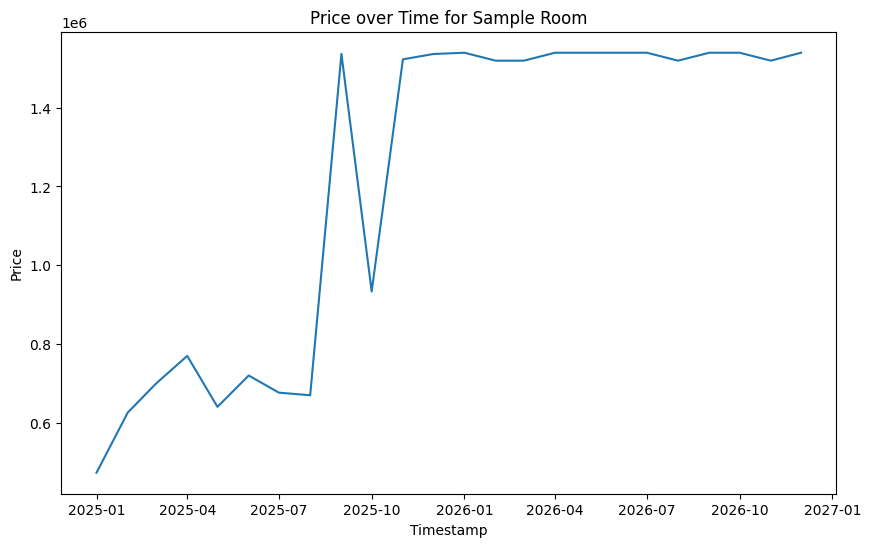

In [ ]:
import matplotlib.pyplot as plt

# Sample one room
sample_room = df_filled[df_filled['hotel_id'] == df_filled['hotel_id'].unique()[0]]

# Plot the price over time
plt.figure(figsize=(10,6))
plt.plot(sample_room['timestamp'], sample_room['price_1_day'])
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price over Time for Sample Room')
plt.show()


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
results = {}
# Loop through each hotel room
#21.03498,105.80881
for hotel_id in df_filled['hotel_id'].unique():
    hotel_data = df_filled[df_filled['hotel_id'] == hotel_id]

    # Split data into training and testing sets
    train_size = int(len(hotel_data) * 0.9)
    train_data, test_data = hotel_data[:train_size], hotel_data[train_size:]

    # ARIMA model
    arima_model = ARIMA(train_data['price_1_day'], order=(10,1,1))
    arima_model_fit = arima_model.fit()
    arima_forecast = arima_model_fit.forecast(steps=len(test_data))
    arima_mse = mean_squared_error(test_data['price_1_day'], arima_forecast)
    arima_rmse = arima_mse ** 0.5
    arima_mae = mean_absolute_error(test_data['price_1_day'], arima_forecast)
    arima_mape = (abs(test_data['price_1_day'] - arima_forecast) / test_data['price_1_day']).mean() * 100
    arima_r2 = r2_score(test_data['price_1_day'], arima_forecast)

    # SARIMA model
    sarima_model = SARIMAX(train_data['price_1_day'], order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_model_fit = sarima_model.fit()
    sarima_forecast = sarima_model_fit.forecast(steps=len(test_data))
    sarima_mse = mean_squared_error(test_data['price_1_day'], sarima_forecast)
    sarima_rmse = sarima_mse ** 0.5
    sarima_mae = mean_absolute_error(test_data['price_1_day'], sarima_forecast)
    sarima_mape = (abs(test_data['price_1_day'] - sarima_forecast) / test_data['price_1_day']).mean() * 100
    sarima_r2 = r2_score(test_data['price_1_day'], sarima_forecast)

    # Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data[['timestamp', 'price_1_day']].rename(columns={'timestamp': 'ds', 'price_1_day': 'y'}))

    # Generate future dataframe with the same number of samples as the test data
    prophet_future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
    prophet_forecast = prophet_model.predict(prophet_future)

    # Select only the forecasted values that match the test data
    prophet_forecast = prophet_forecast[-len(test_data):]

    prophet_mse = mean_squared_error(test_data['price_1_day'], prophet_forecast['yhat'])
    prophet_rmse = prophet_mse ** 0.5
    prophet_mae = mean_absolute_error(test_data['price_1_day'], prophet_forecast['yhat'])
    prophet_mape = (abs(test_data['price_1_day'] - prophet_forecast['yhat']) / test_data['price_1_day']).mean() * 100
    prophet_r2 = r2_score(test_data['price_1_day'], prophet_forecast['yhat'])


    # Print results
    # print(f'Hotel ID: {hotel_id}')
    # print('ARIMA:')
    # print(f'MSE: {arima_mse:.2f}')
    # print(f'RMSE: {arima_rmse:.2f}')
    # print(f'MAE: {arima_mae:.2f}')
    # print(f'MAPE: {arima_mape:.2f}%')
    # print(f'R2: {arima_r2:.2f}')
    # print('SARIMA:')
    # print(f'MSE: {sarima_mse:.2f}')
    # print(f'RMSE: {sarima_rmse:.2f}')
    # print(f'MAE: {sarima_mae:.2f}')
    # print(f'MAPE: {sarima_mape:.2f}%')
    # print(f'R2: {sarima_r2:.2f}')
    # print('Prophet:')
    # print(f'MSE: {prophet_mse:.2f}')
    # print(f'RMSE: {prophet_rmse:.2f}')
    # print(f'MAE: {prophet_mae:.2f}')
    # print(f'MAPE: {prophet_mape:.2f}%')
    # print(f'R2 : {prophet_r2:.2f}%')
    # print('------------------------')

    # Store results in a dictionary
    results[hotel_id] = {
        'ARIMA': {'MSE': arima_mse, 'RMSE': arima_rmse, 'MAE': arima_mae, 'MAPE': arima_mape, 'R2': arima_r2},
        'SARIMA': {'MSE': sarima_mse, 'RMSE': sarima_rmse, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'R2': sarima_r2},
        'Prophet': {'MSE': prophet_mse, 'RMSE': prophet_rmse, 'MAE': prophet_mae, 'MAPE': prophet_mape, 'R2': prophet_r2}
    }

# Calculate average objective values
avg_arima_mse = np.mean([results[hotel_id]['ARIMA']['MSE'] for hotel_id in results])
avg_arima_rmse = np.mean([results[hotel_id]['ARIMA']['RMSE'] for hotel_id in results])
avg_arima_mae = np.mean([results[hotel_id]['ARIMA']['MAE'] for hotel_id in results])
avg_arima_mape = np.mean([results[hotel_id]['ARIMA']['MAPE'] for hotel_id in results])
avg_arima_r2 = np.mean([results[hotel_id]['ARIMA']['R2'] for hotel_id in results])

avg_sarima_mse = np.mean([results[hotel_id]['SARIMA']['MSE'] for hotel_id in results])
avg_sarima_rmse = np.mean([results[hotel_id]['SARIMA']['RMSE'] for hotel_id in results])
avg_sarima_mae = np.mean([results[hotel_id]['SARIMA']['MAE'] for hotel_id in results])
avg_sarima_mape = np.mean([results[hotel_id]['SARIMA']['MAPE'] for hotel_id in results])
avg_sarima_r2 = np.mean([results[hotel_id]['SARIMA']['R2'] for hotel_id in results])

avg_prophet_mse = np.mean([results[hotel_id]['Prophet']['MSE'] for hotel_id in results])
avg_prophet_rmse = np.mean([results[hotel_id]['Prophet']['RMSE'] for hotel_id in results])
avg_prophet_mae = np.mean([results[hotel_id]['Prophet']['MAE'] for hotel_id in results])
avg_prophet_mape = np.mean([results[hotel_id]['Prophet']['MAPE'] for hotel_id in results])
avg_prophet_r2 = np.mean([results[hotel_id]['Prophet']['R2'] for hotel_id in results])

# Print average objective values
print('Average Objective Values:')
print('ARIMA:')
print(f'MSE: {avg_arima_mse:.2f}')
print(f'RMSE: {avg_arima_rmse:.2f}')
print(f'MAE: {avg_arima_mae:.2f}')
print(f'MAPE: {avg_arima_mape:.2f}%')
print(f'R2: {avg_arima_r2:.2f}')
print('SARIMA:')
print(f'MSE: {avg_sarima_mse:.2f}')
print(f'RMSE: {avg_sarima_rmse:.2f}')
print(f'MAE: {avg_sarima_mae:.2f}')
print(f'MAPE: {avg_sarima_mape:.2f}%')
print(f'R2: {avg_sarima_r2:.2f}')
print('Prophet:')
print(f'MSE: {avg_prophet_mse:.2f}')
print(f'RMSE: {avg_prophet_rmse:.2f}')
print(f'MAE: {avg_prophet_mae:.2f}')
print(f'MAPE: {avg_prophet_mape:.2f}%')
print(f'R2: {avg_prophet_r2:.2f}')

# Find hotel_id with optimal objective
optimal_hotel_id = min(results, key=lambda x: results[x]['ARIMA']['MSE'])
print(f'Optimal Hotel ID: {optimal_hotel_id}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

Average Objective Values:
ARIMA:
MSE: 7981762366.88
RMSE: 34091.80
MAE: 26182.59
MAPE: nan%
R2: -411497837957429184.00
SARIMA:
MSE: 149857104941.71
RMSE: 172632.26
MAE: 156169.38
MAPE: nan%
R2: -346181357111871346294390784.00
Prophet:
MSE: 13559169940.42
RMSE: 46972.20
MAE: 41091.77
MAPE: nan%
R2: -60390443956811040634699776.00
Optimal Hotel ID: 21.02911,105.84296


In [ ]:
mse_values = [results[hotel_id][model]['MSE'] for hotel_id in results for model in results[hotel_id]]
mse_values.sort()

print("5 Smallest MSE Values:")
print(mse_values[:50])

print("\n5 Largest MSE Values:")
print(mse_values[-5:])

rmse_values = [results[hotel_id][model]['RMSE'] for hotel_id in results for model in results[hotel_id]]
rmse_values.sort()

print("\n5 Smallest RMSE Values:")
print(rmse_values[:50])

print("\n5 Largest RMSE Values:")
print(rmse_values[-5:])

mae_values = [results[hotel_id][model]['MAE'] for hotel_id in results for model in results[hotel_id]]
mae_values.sort()

print("\n5 Smallest MAE Values:")
print(mae_values[:20])

print("\n5 Largest MAE Values:")
print(mae_values[-5:])

mape_values = [results[hotel_id][model]['MAPE'] for hotel_id in results for model in results[hotel_id]]
mape_values.sort()

print("\n5 Smallest MAPE Values:")
print(mape_values[:20])

print("\n5 Largest MAPE Values:")
print(mape_values[-5:])

r2_values = [results[hotel_id][model]['R2'] for hotel_id in results for model in results[hotel_id]]
r2_values.sort()

print("\n5 Smallest R2 Values:")
print(r2_values[:20])

print("\n5 Largest R2 Values:")
print(r2_values[-20:])


import numpy as np

mse_values = np.array([results[hotel_id][model]['MSE'] for hotel_id in results for model in results[hotel_id]])

print("5 Smallest MSE Values:")
print(np.sort(mse_values)[:5])

print("\n5 Largest MSE Values:")
print(np.sort(mse_values)[-5:])

# Repeat for RMSE, MAE, MAPE, R2


5 Smallest MSE Values:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.278837215177937e-21, 4.174178364069192e-20, 107525.75631651642, 211419.05293943206, 231554.19213286132, 231633.56496676008, 231634.77464164104, 382330.93068223103, 9665013.649759954, 10296896.664659962, 12412763.285191884, 12900525.792068742, 13036975.049672168, 16287804.090276463, 17083921.364366587, 18240419.330402523, 18933406.48536035, 19989615.20927532, 20040601.747452743, 20467267.243276108, 20658899.300227504, 22576216.559017427]

5 Largest MSE Values:
[2049572922289.0176, 2225788450050.293, 4053050097595.4487, 9702757978065.912, 18059288840508.71]

5 Smallest RMSE Values:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.726113180140554e-11, 2.0430806063562917e-10, 327.9112018771491, 459.8032763469961, 481.2007815173011, 48

In [ ]:
df_filled['hotel_id'].unique()

array(['21.0267,105.8421', '21.0212,105.8474', '21.0424,105.838',
       '21.027,105.8513', '21.03582,105.84814', '21.0419,105.8461',
       '21.0353,105.8226', '21.0317,105.8521', '21.0015,105.7855',
       '21.0446,105.817', '21.06999,105.82401', '21.02285,105.8539',
       '21.0318,105.8444', '21.0352,105.8526', '21.03488,105.8485',
       '21.0006,105.784', '21.0372,105.8459', '21.0353,105.8476',
       '21.0321,105.8557', '21.032,105.8415', '21.0365,105.8466',
       '21.02972,105.8485', '20.99071,105.944', '21.02911,105.84296',
       '21.0447,105.8177', '21.03498,105.80881', '21.0388,105.8453',
       '21.0264,105.8583', '21.0303,105.8563', '21.0308,105.8559',
       '21.0456,105.8426', '21.0375,105.8454', '21.02258,105.85364',
       '21.05351,105.83573', '21.02873,105.84746', '21.0278,105.8431',
       '21.06879,105.82383', '21.0238,105.853', '20.99518,105.94193',
       '21.0008,105.7837', '21.0319,105.8415', '21.0325,105.8464',
       '21.0384,105.8468', '21.037,105.8506', '

In [ ]:
optimal_hotel_id = '21.03582,105.84814'

hotel_data = df_filled[df_filled['hotel_id'] == optimal_hotel_id]

hotel_data.shape

(28, 5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

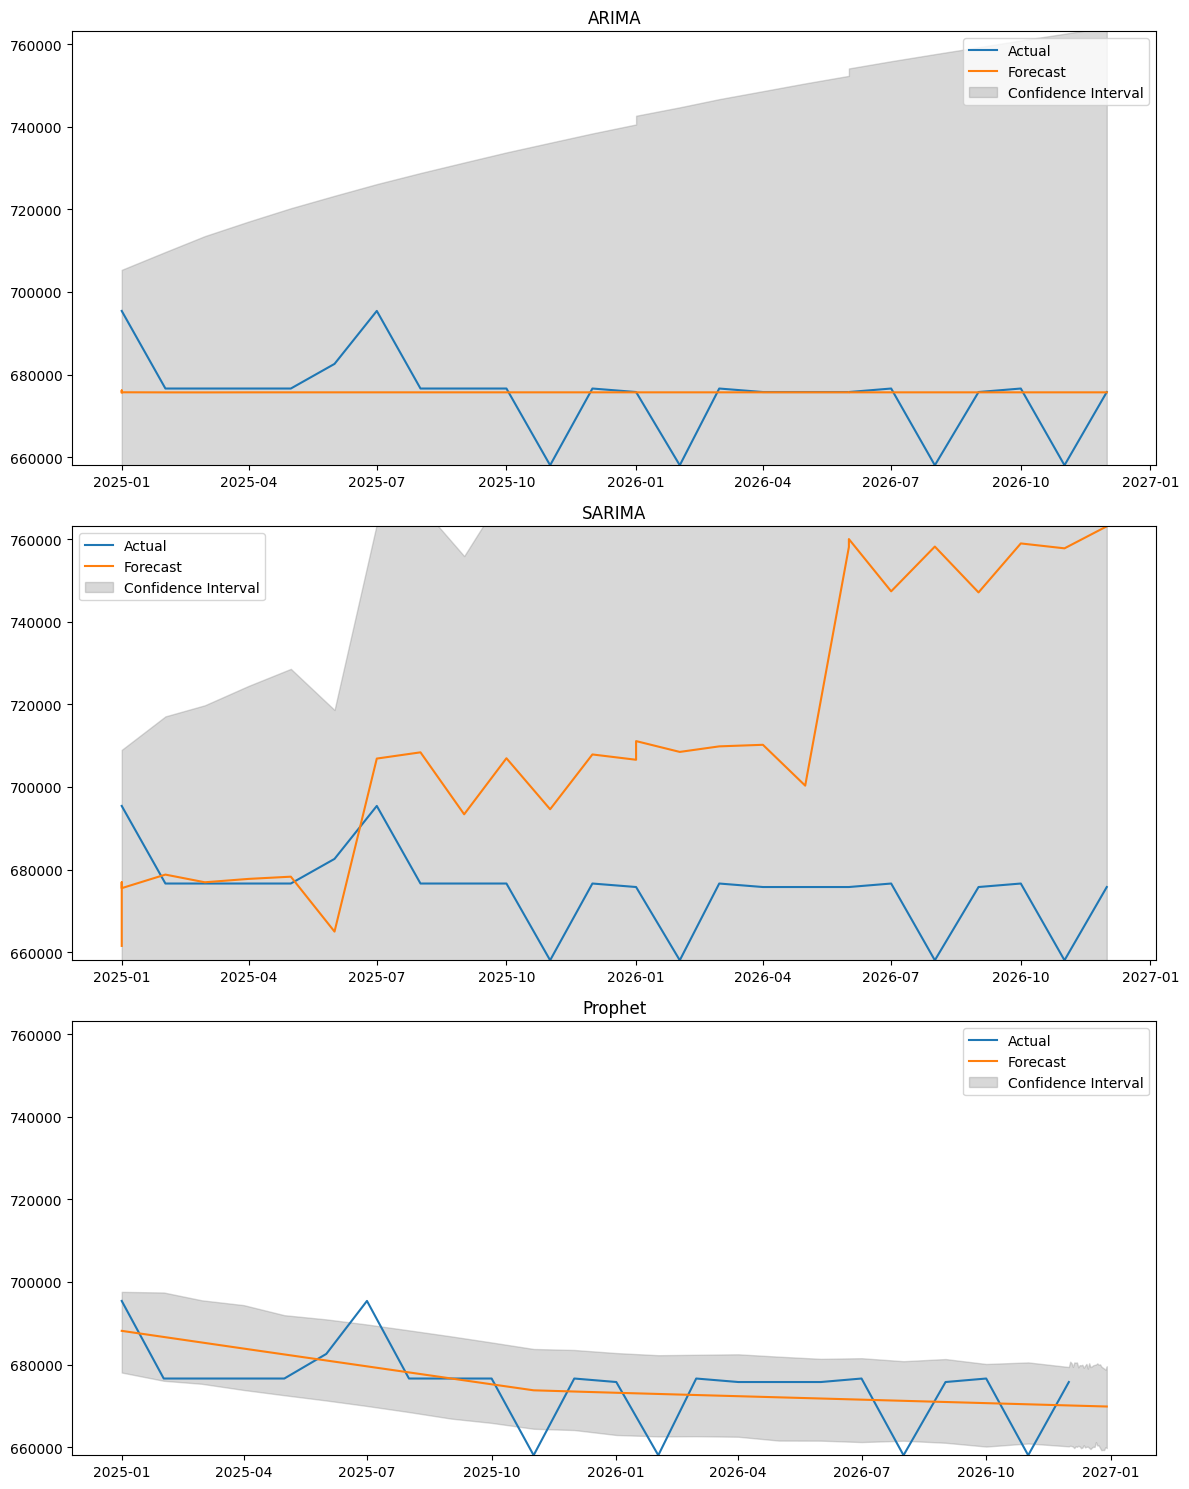

In [ ]:
import matplotlib.pyplot as plt

# ARIMA model
arima_model = ARIMA(hotel_data['price_1_day'], order=(5,1,1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(hotel_data))
arima_ci = arima_model_fit.get_forecast(steps=len(hotel_data)).conf_int()

# SARIMA model
sarima_model = SARIMAX(hotel_data['price_1_day'], order=(5,1,1), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.forecast(steps=len(hotel_data))
sarima_ci = sarima_model_fit.get_forecast(steps=len(hotel_data)).conf_int()

# Prophet model
prophet_model = Prophet()
prophet_model.fit(hotel_data[['timestamp', 'price_1_day']].rename(columns={'timestamp': 'ds', 'price_1_day': 'y'}))
prophet_future = prophet_model.make_future_dataframe(periods=len(hotel_data))
prophet_forecast = prophet_model.predict(prophet_future)
prophet_ci = prophet_forecast[['yhat_lower', 'yhat_upper']]

# Create plots
fig, axs = plt.subplots(3, figsize=(12, 15))

axs[0].plot(hotel_data['timestamp'], hotel_data['price_1_day'], label='Actual')
axs[0].plot(hotel_data['timestamp'], arima_forecast, label='Forecast')
axs[0].fill_between(hotel_data['timestamp'], arima_ci['lower price_1_day'], arima_ci['upper price_1_day'], color='gray', alpha=0.3, label='Confidence Interval')
axs[0].set_title('ARIMA')
axs[0].legend()

axs[1].plot(hotel_data['timestamp'], hotel_data['price_1_day'], label='Actual')
axs[1].plot(hotel_data['timestamp'], sarima_forecast, label='Forecast')
axs[1].fill_between(hotel_data['timestamp'], sarima_ci['lower price_1_day'], sarima_ci['upper price_1_day'], color='gray', alpha=0.3, label='Confidence Interval')
axs[1].set_title('SARIMA')
axs[1].legend()

axs[2].plot(hotel_data['timestamp'], hotel_data['price_1_day'], label='Actual')
axs[2].plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Forecast')
axs[2].fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.3, label='Confidence Interval')
axs[2].set_title('Prophet')
axs[2].legend()

# Set the same y-axis limits for all three subplots
min_y = min(hotel_data['price_1_day'].min(), arima_forecast.min(), sarima_forecast.min(), prophet_forecast['yhat'].min())
max_y = max(hotel_data['price_1_day'].max(), arima_forecast.max(), sarima_forecast.max(), prophet_forecast['yhat'].max())
for ax in axs:
    ax.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()

      Unnamed: 0       lat        lon  price_1_day  Bếp  \
0            192  21.03640  105.84730      1112610  0.0   
1            194  21.02700  105.85130       583333  1.0   
2            196  21.02120  105.84740       548684  1.0   
3            197  21.03488  105.84850       441375  0.0   
4            199  21.02285  105.85390       674678  1.0   
...          ...       ...        ...          ...  ...   
3829        6368  21.03140  105.84310      1756105  1.0   
3830        6369  21.03086  105.85753      1405555  1.0   
3831        6308  21.03840  105.84680       764000  0.0   
3832        6357  21.02380  105.85300      1805000  1.0   
3833        6417  21.03582  105.84814       675767  1.0   

      Chỗ đỗ xe miễn phí tại nơi ở  Chỗ ở có camera an ninh ngoài nhà  \
0                              0.0                                1.0   
1                              0.0                                0.0   
2                              0.0                                1.0   

              lat        lon  timestamp    price_1_day
0        20.95177  105.93376 2025-01-01  541161.416667
1        20.95177  105.93376 2025-02-01  541161.416667
2        20.95177  105.93376 2025-03-01  541161.416667
3        20.95177  105.93376 2025-04-01  541161.416667
4        20.95177  105.93376 2025-05-01  541161.416667
...           ...        ...        ...            ...
1263931  21.21680  105.78120 2026-08-01  348000.000000
1263932  21.21680  105.78120 2026-09-01  348333.000000
1263933  21.21680  105.78120 2026-10-01  348000.000000
1263934  21.21680  105.78120 2026-11-01  348000.000000
1263935  21.21680  105.78120 2026-12-01  348333.000000

[1263936 rows x 4 columns]


DatetimeIndex(['2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01'],
              dtype='datetime64[ns]', freq='MS')

      Unnamed: 0      lat       lon  price_1_day  Bếp  \
1              9  21.0212  105.8474       552071  1.0   
22            96  21.0212  105.8474       548684  1.0   
41           196  21.0212  105.8474       548684  1.0   
80           334  21.0212  105.8474       677388  1.0   
143          570  21.0212  105.8474       422309  1.0   
155          579  21.0212  105.8474      1110069  1.0   
180          651  21.0212  105.8474      1110069  1.0   
181          652  21.0212  105.8474       386111  0.0   
182          654  21.0212  105.8474       422309  1.0   
246          844  21.0212  105.8474      1029630  1.0   
252          847  21.0212  105.8474       402199  0.0   
278          894  21.0212  105.8474       434375  1.0   
284          923  21.0212  105.8474       434375  1.0   
285          925  21.0212  105.8474       402199  0.0   
296          982  21.0212  105.8474       719724  1.0   
303          949  21.0212  105.8474       434375  1.0   
350         1071  21.0212  105.

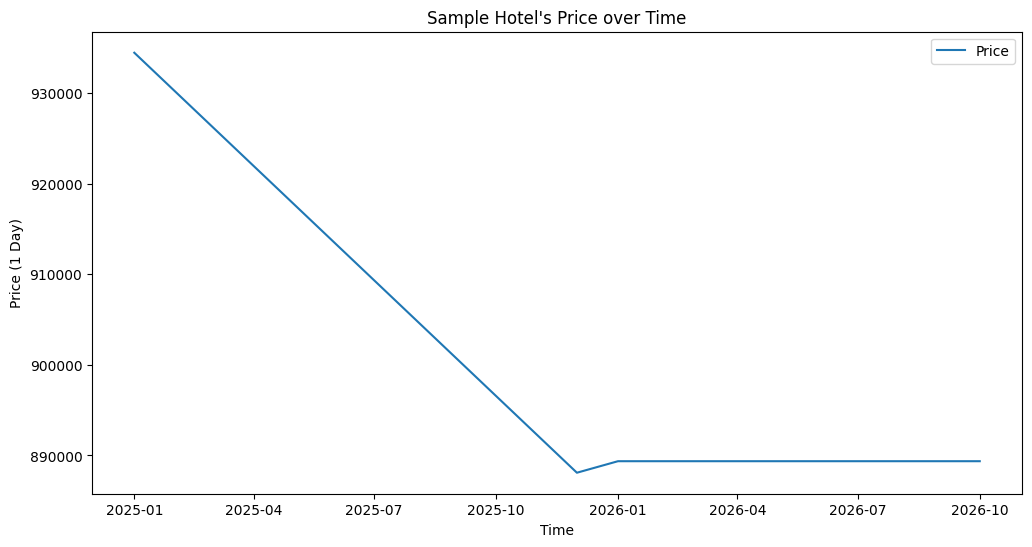